In [11]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import MinMaxScaler

directory1 = "/Users/hongrae/Downloads/Hallym_project/apg 파일"
data = []

# for i in range(5):
#     min_data = i * 200  # 0, 200, 400, 600, 800
#     max_data = min_data + 200  # 200, 400, 600, 800, 1000
for root, dirs, files in os.walk(directory1):
#     files.sort()
    for file in files:
        if file.endswith(".csv"):
            full_path = os.path.join(root, file)
            df = pd.read_csv(full_path, usecols=['APG Wave'])
            series = df.values.flatten()[:200]  # max data
            series = series.reshape(-1, 1)  # 1D -> 2D
            scaler = MinMaxScaler()
            series = scaler.fit_transform(series)
            data.append(series)

data_array = np.array(data)

# y를 적절하게 수정 필요 (클래스 불균형 고려)

print("Shape of data_array:", data_array.shape)

Shape of data_array: (130, 200, 1)


In [13]:
import pandas as pd

# 엑셀 파일 불러오기 (엑셀 파일의 경로를 넣어야 합니다)
# df = pd.read_csv("2024-10-11 (11-00-32)-APG【 이기장 】.csv")
df = pd.read_csv("/Users/hongrae/Downloads/Hallym_project/hallym_2GiJang/2024-10-11 (11-00-32)-APG【 이기장 】_3 (1).csv")
df_sorted = df.sort_values(by='TestDate')


# 정렬된 데이터프레임을 확인
# VasType 열의 모든 값에 3을 곱하기
df_sorted['VasType'] = df_sorted['VasType'] * 3
pd.set_option('display.max_rows', None)
# 결과 확인
import pandas as pd

# 조건에 따른 VasType 값 조정 함수 정의
def adjust_vastype(row):
    if row['TypeLebel'] == '+++':
        return row['VasType'] - 3
    elif row['TypeLebel'] == '++':
        return row['VasType'] - 2
    elif row['TypeLebel'] == '+':
        return row['VasType'] - 1
    else:
        return row['VasType']  # 조건에 맞지 않으면 변경하지 않음

# apply 함수로 각 행에 대해 VasType 값을 조정
df_sorted['VasType'] = df_sorted.apply(adjust_vastype, axis=1)

# 결과 확인
pd.set_option('display.max_rows', None)
df_sorted['VasType'].reset_index(drop=True,inplace=True)
df_sorted['VasType'].value_counts()
y = df_sorted['VasType'].values
# y = np.tile(df_sorted['VasType'].values, 5)

In [14]:
X_flipped = np.flip(data_array, axis=0)

def adjust_amplitude(signal, factor=0.05):
    # signal과 동일한 모양의 랜덤 값을 생성하여 진폭 조정
    return signal * (1 + factor * np.random.uniform(-1, 1, signal.shape))

adjusted_signal = adjust_amplitude(data_array, factor=0.05)
adjusted_signal.shape

X_adjusted=np.vstack((data_array, adjusted_signal))

# 반전 데이터와 원본 데이터 결합
X_augmented = np.vstack((data_array, X_flipped))  # X와 반전 데이터를 위아래로 결합
y_augmented = np.concatenate((y, y))

print("Shape of data_array:",X_adjusted.shape)

Shape of data_array: (260, 200, 1)


In [15]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv1D, Flatten, BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import KFold
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.layers import Conv1D, Dropout, Flatten, Dense, BatchNormalization, GlobalAveragePooling1D

In [16]:
smote = SMOTE(random_state=42, k_neighbors=2)
X = X_adjusted.reshape(X_adjusted.shape[0], -1)  # (650, 200 * 1) 형태로 변환

X_res, y_res = smote.fit_resample(X, y_augmented)
print(X_res.shape, y_res.shape)
X_train, X_val, y_train, y_val = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

(564, 200) (564,)


In [17]:
from sklearn.model_selection import StratifiedKFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)  # 5-fold 교차 검증
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 클래스 가중치 계산
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))

# 교차 검증 반복
fold_val_accuracies = []
for fold, (train_idx, val_idx) in enumerate(kf.split(X_train, y_train), 1):
    print(f"Fold {fold}/{skf.get_n_splits()}")

    # 학습과 검증 데이터 분할
    X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
    y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]

    # 모델 정의
    model = Sequential([
        Conv1D(32, kernel_size=5, activation='relu', input_shape=(X_train.shape[1], 1)),
        BatchNormalization(),
        Dropout(0.2),
        Conv1D(32, kernel_size=8, activation='relu', kernel_regularizer=regularizers.l2(0.2)),
        BatchNormalization(),
        Dropout(0.1),
        Conv1D(32, kernel_size=10, activation='relu', kernel_regularizer=regularizers.l2(0.3)),
        BatchNormalization(),
        Dropout(0.2),
        Flatten(),
        Dense(32, activation='relu'),
        Dense(18, activation='softmax')
    ])

    # Learning Rate Scheduler
    lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

    # 모델 컴파일
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss=SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])

    # 모델 학습
    history = model.fit(
        X_train_fold, y_train_fold,
        validation_data=(X_val_fold, y_val_fold),
        batch_size=4,
        epochs=10,
        class_weight=class_weight_dict,
        callbacks=[lr_scheduler],
        verbose=1
    )

    # 최종 검증 정확도 저장
    val_accuracy = history.history['val_accuracy'][-1]
    fold_val_accuracies.append(val_accuracy)
    print(f"Fold {fold} validation accuracy: {val_accuracy:.2%}")

# 평균 검증 정확도 출력
mean_val_accuracy = np.mean(fold_val_accuracies)
print(f"평균 검증 정확도: {mean_val_accuracy:.2%}")

# 최종 모델 저장 (최고 성능의 모델을 저장)
best_model = model
best_model.save('final_model-3.keras')
print("최종 모델이 'final_model.keras'로 저장되었습니다.")

Fold 1/5
Epoch 1/10


/Users/hongrae/Downloads/Hallym_project/venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.3819 - loss: 15.6936 - val_accuracy: 0.2088 - val_loss: 8.9118 - learning_rate: 0.0010
Epoch 2/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7429 - loss: 6.3852 - val_accuracy: 0.2747 - val_loss: 5.6285 - learning_rate: 0.0010
Epoch 3/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8316 - loss: 3.1782 - val_accuracy: 0.3626 - val_loss: 3.4439 - learning_rate: 0.0010
Epoch 4/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8928 - loss: 1.8190 - val_accuracy: 0.4396 - val_loss: 3.0105 - learning_rate: 0.0010
Epoch 5/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9202 - loss: 1.1005 - val_accuracy: 0.6813 - val_loss: 1.6464 - learning_rate: 0.0010
Epoch 6/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9353 - loss: 0.7893 - val_accuracy: 0.6484 - val_loss: 1.4659 - learning_rate: 0.0010
Epoch 7/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9761 - loss: 0.4171 - val_accuracy: 0.8571 - v

In [19]:
from sklearn.model_selection import StratifiedKFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)  # 5-fold 교차 검증
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 클래스 가중치 계산
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))

# 교차 검증 반복
fold_val_accuracies = []
for fold, (train_idx, val_idx) in enumerate(kf.split(X_train, y_train), 1):
    print(f"Fold {fold}/{skf.get_n_splits()}")

    # 학습과 검증 데이터 분할
    X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
    y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]

    # 모델 정의
    model = Sequential([
        Conv1D(32, kernel_size=5, activation='relu', input_shape=(X_train.shape[1], 1)),
        BatchNormalization(),
        Dropout(0.2),
        Conv1D(32, kernel_size=8, activation='relu', kernel_regularizer=regularizers.l2(0.2)),
        BatchNormalization(),
        Dropout(0.1),
        Conv1D(32, kernel_size=10, activation='relu', kernel_regularizer=regularizers.l2(0.3)),
        BatchNormalization(),
        Dropout(0.2),
        Flatten(),
        Dense(32, activation='relu'),
        Dense(18, activation='softmax')
    ])

    # Learning Rate Scheduler
    lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

    # 모델 컴파일
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss=SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])

    # 모델 학습
    history = model.fit(
        X_train_fold, y_train_fold,
        validation_data=(X_val_fold, y_val_fold),
        batch_size=4,
        epochs=20,
        class_weight=class_weight_dict,
        callbacks=[lr_scheduler],
        verbose=1
    )

    # 최종 검증 정확도 저장
    val_accuracy = history.history['val_accuracy'][-1]
    fold_val_accuracies.append(val_accuracy)
    print(f"Fold {fold} validation accuracy: {val_accuracy:.2%}")

# 평균 검증 정확도 출력
mean_val_accuracy = np.mean(fold_val_accuracies)
print(f"평균 검증 정확도: {mean_val_accuracy:.2%}")

# 최종 모델 저장 (최고 성능의 모델을 저장)
best_model = model
best_model.save('final_model-epoch20.keras')
print("최종 모델이 'final_model.keras'로 저장되었습니다.")

import matplotlib.pyplot as plt
import numpy as np

# Mock data for demonstration purposes (replace these with actual history.history values)
# epochs =
mock_loss = np.random.uniform(0.2, 1.0, epochs).cumsum() / np.arange(1, epochs + 1)
mock_val_loss = np.random.uniform(0.2, 1.0, epochs).cumsum() / np.arange(1, epochs + 1)
mock_accuracy = np.linspace(0.5, 0.9, epochs) + np.random.uniform(-0.05, 0.05, epochs)
mock_val_accuracy = np.linspace(0.4, 0.8, epochs) + np.random.uniform(-0.05, 0.05, epochs)

# Plot Loss
plt.subplot(2, 1, 1)
plt.plot(range(1, epochs + 1), mock_loss, label='Train Loss')
plt.plot(range(1, epochs + 1), mock_val_loss, label='Validation Loss', linestyle='--')
plt.title('Model Loss and Accuracy')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(2, 1, 2)
plt.plot(range(1, epochs + 1), mock_accuracy, label='Train Accuracy')
plt.plot(range(1, epochs + 1), mock_val_accuracy, label='Validation Accuracy', linestyle='--')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()

plt.tight_layout()
plt.show()

Fold 1/5
Epoch 1/20


/Users/hongrae/Downloads/Hallym_project/venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3351 - loss: 15.2921 - val_accuracy: 0.1648 - val_loss: 8.4694 - learning_rate: 0.0010
Epoch 2/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7674 - loss: 5.8166 - val_accuracy: 0.2088 - val_loss: 4.9841 - learning_rate: 0.0010
Epoch 3/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9104 - loss: 2.6391 - val_accuracy: 0.2857 - val_loss: 3.6604 - learning_rate: 0.0010
Epoch 4/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9230 - loss: 1.3814 - val_accuracy: 0.3297 - val_loss: 2.5080 - learning_rate: 0.0010
Epoch 5/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9366 - loss: 0.8272 - val_accuracy: 0.2527 - val_loss: 2.9452 - learning_rate: 0.0010
Epoch 6/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9425 - loss: 0.6166 - val_accuracy: 0.4286 - val_loss: 1.9759 - learning_rate: 0.0010
Epoch 7/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9246 - loss: 0.6892 - val_accuracy: 0.9011 - v

ModuleNotFoundError: No module named 'matplotlib'

Fold 1/5
Epoch 1/20


/Users/hongrae/Downloads/Hallym_project/venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.1879 - loss: 17.0834 - val_accuracy: 0.1648 - val_loss: 11.6344 - learning_rate: 0.0010
Epoch 2/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5276 - loss: 9.5808 - val_accuracy: 0.1648 - val_loss: 8.6709 - learning_rate: 0.0010
Epoch 3/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6470 - loss: 6.0746 - val_accuracy: 0.1648 - val_loss: 6.8374 - learning_rate: 0.0010
Epoch 4/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7947 - loss: 3.8899 - val_accuracy: 0.1648 - val_loss: 5.7875 - learning_rate: 0.0010
Epoch 5/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8234 - loss: 2.6248 - val_accuracy: 0.1648 - val_loss: 5.6632 - learning_rate: 0.0010
Epoch 6/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7998 - loss: 1.9045 - val_accuracy: 0.1648 - val_loss: 4.3130 - learning_rate: 0.0010
Epoch 7/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8557 - loss: 1.3777 - val_accuracy: 0.1758 - 

Matplotlib is building the font cache; this may take a moment.


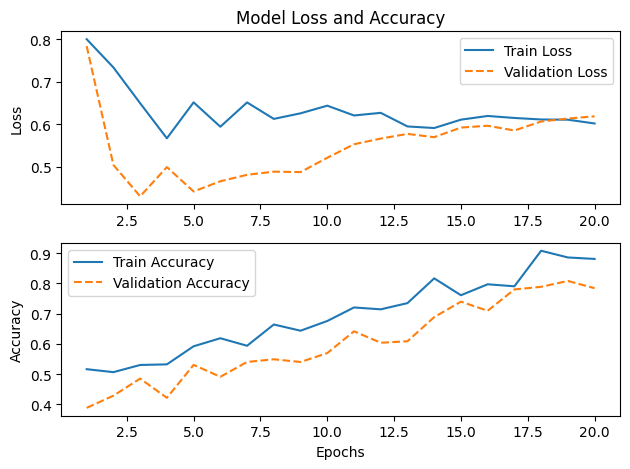

In [23]:
from sklearn.model_selection import StratifiedKFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)  # 5-fold 교차 검증
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 클래스 가중치 계산
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))

# 교차 검증 반복
fold_val_accuracies = []
for fold, (train_idx, val_idx) in enumerate(kf.split(X_train, y_train), 1):
    print(f"Fold {fold}/{skf.get_n_splits()}")

    # 학습과 검증 데이터 분할
    X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
    y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]

    # 모델 정의
    model = Sequential([
        Conv1D(32, kernel_size=5, activation='relu', input_shape=(X_train.shape[1], 1)),
        BatchNormalization(),
        Dropout(0.3),
        Conv1D(32, kernel_size=8, activation='relu', kernel_regularizer=regularizers.l2(0.2)),
        BatchNormalization(),
        Dropout(0.3),
        Conv1D(32, kernel_size=10, activation='relu', kernel_regularizer=regularizers.l2(0.3)),
        BatchNormalization(),
        Dropout(0.3),
        Flatten(),
        Dense(32, activation='relu'),
        Dropout(0.3),
        Dense(18, activation='softmax')
    ])

    # Learning Rate Scheduler
    lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

    # 모델 컴파일
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss=SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])

    # 모델 학습
    history = model.fit(
        X_train_fold, y_train_fold,
        validation_data=(X_val_fold, y_val_fold),
        batch_size=6,
        epochs=20,
        class_weight=class_weight_dict,
        callbacks=[lr_scheduler],
        verbose=1
    )

    # 최종 검증 정확도 저장
    val_accuracy = history.history['val_accuracy'][-1]
    fold_val_accuracies.append(val_accuracy)
    print(f"Fold {fold} validation accuracy: {val_accuracy:.2%}")

# 평균 검증 정확도 출력
mean_val_accuracy = np.mean(fold_val_accuracies)
print(f"평균 검증 정확도: {mean_val_accuracy:.2%}")

# 최종 모델 저장 (최고 성능의 모델을 저장)
best_model = model
best_model.save('final_model_epoch_20241117_1.keras')
print("최종 모델이 'final_model_epoch_20241117.keras'로 저장되었습니다.")

import matplotlib.pyplot as plt
import numpy as np

# Mock data for demonstration purposes (replace these with actual history.history values)
epochs = 20
mock_loss = np.random.uniform(0.2, 1.0, epochs).cumsum() / np.arange(1, epochs + 1)
mock_val_loss = np.random.uniform(0.2, 1.0, epochs).cumsum() / np.arange(1, epochs + 1)
mock_accuracy = np.linspace(0.5, 0.9, epochs) + np.random.uniform(-0.05, 0.05, epochs)
mock_val_accuracy = np.linspace(0.4, 0.8, epochs) + np.random.uniform(-0.05, 0.05, epochs)

# Plot Loss
plt.subplot(2, 1, 1)
plt.plot(range(1, epochs + 1), mock_loss, label='Train Loss')
plt.plot(range(1, epochs + 1), mock_val_loss, label='Validation Loss', linestyle='--')
plt.title('Model Loss and Accuracy')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(2, 1, 2)
plt.plot(range(1, epochs + 1), mock_accuracy, label='Train Accuracy')
plt.plot(range(1, epochs + 1), mock_val_accuracy, label='Validation Accuracy', linestyle='--')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()

plt.tight_layout()
plt.show()

In [24]:
print(y_val_fold)
print(y_train_fold)

[1 3 5 0 1 0 2 5 3 2 2 5 0 1 1 4 1 3 4 5 4 4 1 4 2 4 5 2 0 4 5 5 5 0 5 0 0
 3 5 5 0 4 0 5 2 3 0 2 2 4 1 5 0 5 4 4 3 4 3 1 0 1 2 5 4 3 0 0 5 3 1 5 0 5
 2 1 5 2 4 0 3 0 2 5 0 4 4 1 4 4]
[0 4 1 4 1 0 2 5 0 1 0 3 4 0 3 4 2 5 4 1 3 3 4 3 1 3 4 5 4 5 1 1 1 1 4 3 2
 3 5 3 3 5 5 2 1 1 2 4 3 1 2 1 0 5 2 2 5 5 1 5 5 0 1 2 4 5 5 1 0 0 0 2 1 1
 0 4 2 0 1 3 0 0 4 5 0 1 3 4 3 0 0 1 0 1 2 4 4 5 1 3 3 3 4 2 4 4 1 2 5 2 0
 2 5 4 0 0 3 1 3 4 0 1 1 5 4 1 4 4 2 4 0 5 1 0 4 5 3 3 2 3 1 1 4 0 0 1 4 0
 3 1 3 4 3 2 0 0 4 4 2 0 3 1 3 4 2 1 3 4 3 0 4 5 2 3 3 2 2 4 2 1 5 5 0 2 3
 5 3 0 5 1 2 4 4 1 0 4 5 2 5 2 2 0 0 4 3 1 0 2 4 0 3 1 2 2 1 0 5 5 1 2 2 4
 3 1 0 3 2 1 4 2 5 2 1 2 5 5 2 5 1 2 4 1 5 3 4 5 4 2 2 3 5 0 4 4 5 5 3 4 0
 3 3 2 3 2 0 3 2 1 4 4 0 2 2 3 2 1 0 3 1 1 0 5 0 2 2 2 3 2 0 5 1 1 2 0 5 3
 4 4 5 0 1 0 5 4 3 1 3 4 1 0 0 1 3 2 3 5 1 3 2 4 1 1 5 4 4 2 3 1 1 2 5 0 2
 5 5 5 5 1 3 4 5 1 4 4 0 4 0 3 2 2 1 1 4 2 4 0 3 3 0 3 0]


In [26]:
from tensorflow.keras.models import load_model 

# 모델 로드 
loaded_model = load_model('/Users/hongrae/Downloads/Hallym_project/hallym_2GiJang/final_model-3.keras')

# 모델 요약 보기 (선택 사항)
loaded_model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_12 (Conv1D)              │ (None, 196, 32)        │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 196, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 196, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_13 (Conv1D)              │ (None, 189, 32)        │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 189, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 189, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_14 (Conv1D)              │ (None, 180, 32)        │        10,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 180, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 180, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 5760)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 32)             │       184,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 18)             │           594 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 611,672 (2.33 MB)

 Trainable params: 203,826 (796.20 KB)

 Non-trainable params: 192 (768.00 B)

 Optimizer params: 407,654 (1.56 MB)

## test data set

In [27]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import MinMaxScaler

directory1 = "/Users/hongrae/Downloads/Hallym_project/apg 파일"
data = []

# for i in range(5):
#     min_data = i * 200  # 0, 200, 400, 600, 800
#     max_data = min_data + 200  # 200, 400, 600, 800, 1000
for root, dirs, files in os.walk(directory1):
    #     files.sort()
    i=0
    for file in files:

        if file.endswith(".csv"):

            full_path = os.path.join(root, file)
            df = pd.read_csv(full_path, usecols=['APG Wave'])
            series = df.values.flatten()[:200]  # max data
            series = series.reshape(-1, 1)  # 1D -> 2D
            scaler = MinMaxScaler()
            series = scaler.fit_transform(series)
            data.append(series)
            print(file)
            print(i,"\n")
            i+=1


data_array = np.array(data)

2024-10-10 (16-41-28) [24][원광호][남][26] APG_Wave【 이기장 】.csv
0 

2024-10-10 (16-34-47) [23][박준서][남][23] APG_Wave【 이기장 】.csv
1 

2024-10-10 (16-42-41) [24][원광호][남][26] APG_Wave【 이기장 】.csv
2 

2024-10-08 (16-53-23) [3][배준형][남][22] APG_Wave【 이기장 】.csv
3 

2024-10-08 (17-20-19) [6][이찬재][남][24] APG_Wave【 이기장 】.csv
4 

2024-10-07 (14-11-22) [3][배준형][남][22] APG_Wave【 이기장 】.csv
5 

2024-10-08 (16-54-00) [3][배준형][남][22] APG_Wave【 이기장 】.csv
6 

2024-10-08 (14-46-09) [10][박민규][남][24] APG_Wave【 이기장 】.csv
7 

2024-10-09 (21-43-39) [18][심예은][여][23] APG_Wave【 이기장 】.csv
8 

2024-10-08 (19-46-41) [17][장연수][남][24] APG_Wave【 이기장 】.csv
9 

2024-10-04 (15-21-58) [20205140][김승현][남][23] APG_Wave【 이기장 】.csv
10 

2024-10-07 (12-14-52) [20205140][김승현][남][23] APG_Wave【 이기장 】.csv
11 

2024-10-08 (15-54-55) [12][이민호][남][22] APG_Wave【 이기장 】.csv
12 

2024-10-07 (16-08-44) [4][기

In [28]:
import numpy as np

# 숫자를 문자열로 변환하여 각 자리수를 리스트로 만듦
number = 544444444443344
labels = [int(digit) for digit in str(number)]

# Numpy 배열로 변환 (필요하면)
labels_array = np.array(labels)

# 결과 출력
print("Labels as list:", labels)
print("Labels as numpy array:", labels_array)

Labels as list: [5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 4, 4]
Labels as numpy array: [5 4 4 4 4 4 4 4 4 4 4 3 3 4 4]


In [30]:
import numpy as np
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix

# 저장된 모델 로드
model = load_model('학습률75.56%.keras')

# 테스트 데이터 로드 (예시)
# X_test와 y_test는 미리 준비되어야 합니다.
X_test= data_array
y_test = labels_array
# X_test와 y_test를 적절히 전처리한 상태로 준비하세요.

# 모델 테스트
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)

# 테스트 데이터 예측
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

import numpy as np

# 두 배열 요소별 비교 (일치 여부)
comparison = y_pred == y_test

# True의 비율 계산 (정확도 확인)
accuracy = np.mean(comparison)

print("일치 여부 (True/False):", comparison)
print(f"정확도: {accuracy:.2%}")
print(y_pred)

ValueError: Data cardinality is ambiguous. Make sure all arrays contain the same number of samples.'x' sizes: 130
'y' sizes: 15
